# KAPSÜL AĞLARI 


---


**Orijinal Makale:** [Dynamic Routing Between Capsules](https://arxiv.org/abs/1710.09829)
[<img align="right" width="100" height="100" src="http://www.i2symbol.com/images/symbols/style-letters/circled_latin_capital_letter_a_u24B6_icon_128x128.png">](https://www.ayyucekizrak.com/)

**Yazarlar: **Sara Sabour, Nicholas Frosst and Geoffrey E. Hinton (NIPS 2017)



***Gerçekleme için kaynak:*** Aurelien Geron, [CapsNet TenforFlow Implementation](https://colab.research.google.com/github/ageron/handson-ml/blob/master/extra_capsnets.ipynb#scrollTo=bpznizHXoa-z)


---




## Gerekli Kütüphanelerin Yüklenmesi
Python 2 ve Python 3 destekler!

In [0]:
from __future__ import division, print_function, unicode_literals

Şekilleri çizdirmek için:

In [0]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

NumPy ve TensorFlow kütüphanelerine ihtiyacımız olacak!

In [0]:
import numpy as np
import tensorflow as tf

## Tekrarlanabilirlik

Çekirdeği (Kernel) yeniden başlatmadan bu not defterini yeniden çalıştırmanız durumunda varsayılan grafiği sıfırlayalım:

In [0]:
tf.reset_default_graph()

Rastgele çekirdeklerin ayarlanması:

In [0]:
np.random.seed(42)
tf.set_random_seed(42)

## MNIST Veri Setini Yükleme

Evet biliyorum, yine MNIST! :)
Ama umarım bu güçlü model, daha büyük veri setlerinde de işe yarayacaktır fakat çok zaman alacaktır.

In [0]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Bu el yazısıyla yazılmış rakamların neye benzediğine bakalım:

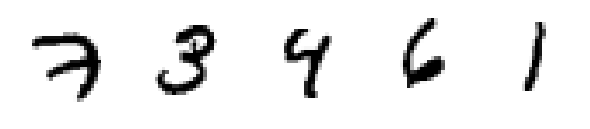

In [0]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = mnist.train.images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

Ve tabi ki etiketlerine de bakalım:;

In [0]:
mnist.train.labels[:n_samples]

array([7, 3, 4, 6, 1], dtype=uint8)

Şimdi bu görüntüleri sınıflandırmak için bir Kapsül Ağı kuralım.

İşte genel mimari aşağıdaki gibi, ASCII sanatının tadını çıkarın! ;-)

Not: okunabilirlik için iki ok çıkardım:
Etiketler → Maske ve Giriş Görüntüleri → Yeniden Yapılandırma Kaybı.

```
                            Kayıp
                              ↑
                    ┌─────────┴─────────┐
      Etiketler → Marj Kaybı      Yeniden Yapılandırma Kaybı
                    ↑                   ↑
                  Uzunluk             Kodçözücü
                    ↑                   ↑ 
             Dijit Kapsül ────Maske────┘
               ↖↑↗ ↖↑↗ ↖↑↗
             Öncül Kapsüller
                    ↑      
              Giriş Görüntüsü
```

Grafiği alt katmandan başlayarak oluşturacağız ve yavaşça önce sol tarafa doğru hareket edeceğiz. 

Kolları sıvayalım!

## Giriş Görüntüleri

Giriş görüntüleri için bir  `placeholder ` oluşturarak başlayalım (28 × 28 piksel, 1 renk kanalı = siyah-beyaz görüntü).



In [0]:
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")

## Öncül Kapsül

İlk katman, her kapsülün bir 8 uzunluklu aktivasyon vektörünü çıkaracağı, her biri 6 x 6 kapsülden oluşan 32 haritadan oluşacaktır:

In [0]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8

Çıktıları hesaplamak için öncelikle iki standart evrişim katmanı uygulanır:

In [0]:
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

In [0]:
conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)
conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)

**Not: ** Kernel boyutu:9 ve piksel ekleme (padding) uygulanmadığında ( `valid ` kullanılmış olması bu yüzdendir) Evrişim işlemi sonucunda görüntüler 9-1=8 piksel durumuna gelir. Evrişim katmanı (28×28 den 20×20 ye, sonra da 20×20 dan12×12 ye) ve ikinci evrişim katmanında adım kaydırma (stride) olarak 2 seçiyoruz. Böylece son görüntü 2'ye bölünmüş oluyor ve bize kalan öznitelik haritası 6x6 boyutlu oluyor.

Öncül kapsüllerin çıktılarını temsil eden bir dizi 8 uzunluklu vektörü elde etmek için çıktıyı yeniden boyutlandırıyoruz.

`Conv2` çıkışı, her bir özellik haritasının 6 × 6 olduğu her bir örnek için 32 × 8 = 256 özellikli bir harita içeren bir dizidir. Yani bu çıktının şekli (toplu boyut, 6, 6, 256) şeklindedir.

256'yı her biri 8 boyutta 32 vektöre ayırmak istiyoruz. Bunu yeniden şekillendirerek yapabiliriz (küme boyutu (batch size), 6, 6, 32, 8).

Bununla birlikte, bu birinci kapsül katmanı bir sonraki kapsül katmanına tamamen bağlanacağından, 6 × 6 gridler flat hale getirilebiliriz.

Bu sadece yeniden boyutlandırma için `reshape` gerektiği anlamına gelir (küme boyutu boyutu, 6 × 6 × 32, 8).

In [0]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")

Sıra geldi makalede bahsi geçen `squash` yani `ezme` fonksiyonuna! `squash()` makalede gösterilen (1) denklemdir ve şu şekilde tanımlayabiliriz:

$\operatorname{squash}(\mathbf{s}) = {ezme}(\mathbf{s}) =\dfrac{\|\mathbf{s}\|^2}{1 + \|\mathbf{s}\|^2} \dfrac{\mathbf{s}}{\|\mathbf{s}\|}$

`squash()` fonksiyonu girişindeki dizileri verilen eksen boyunca düzenler.

**Dikkat**, $\|\mathbf{s}\|$ normu eğer türevlendiğinde $\|\mathbf{s}\|=0$ olarak elde edilirse maalesef ezme fonksiyonunda belirsizlik meydana geliyor ve bu istenmeyen bir durumdur. Bu yüzden sadece `tf.norm()` kullanamayız. Bu koşulda eğitim işlemimiz gerçekleşmez sıfırlar yüzünden tanımsızlar uzayında kitlenir kalırız. Bu problemi aşmak için küçük bir epsilon değeri ile s kareler ile toplayıp bunların karekökünü almamız gerek: $\|\mathbf{s}\| \approx \sqrt{\sum\limits_i{{s_i}^2}\,\,+ \epsilon}$.

In [0]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

Her $i.$ öncül kapsül için $\mathbf{u}_i$çıkışının hesabı:

In [0]:
caps1_output = squash(caps1_raw, name="caps1_output")

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Harika! İlk kapsül katmanının çıkışlarını elde ettik.
Çok zor değildi, değil mi?

Bununla birlikte, bir sonraki katmanın hesaplanması eğlencenin gerçekten başladığı yerdir :)

## DİJİT KAPSÜL

Dijit kapsülün çıkışlarını hesaplamak için, öncelikle çıkış vektör kestirimlerini hesaplamamız gerekmektedir. Ardından *anlaşmalı yönlendirme algoritmas*ına geçebileceğiz.

### Tahmin Edilen Çıkış Vektörlerinin Hesabı

Her dijit kapsül katmanı her biri 16 boyutlu 10 kapsülden meydana gelmektedir:

In [0]:
caps2_n_caps = 10
caps2_n_dims = 16

İlk kapsül katmanında her  $i$ için her bir kapsül için  $j$ yi kestirmek istiyoruz, ikinci katman için. Bunun için $\mathbf{W}_{i,j}$ matrisine ihtiyaç vardır. Böylece $\hat{\mathbf{u}}_{j|i} = \mathbf{W}_{i,j} \, \mathbf{u}_i$ hesabını yapabiliriz. Makalede (2) denklem olarak verilmektedir. Bir 8D vektörünü bir 16D vektörüne dönüştürmek istediğimizden, her bir dönüşüm matrisi $\mathbf{W}_{i,j}$' nin bir hali olmalıdır (16, 8).

 $\hat{\mathbf{u}}_{j|i}$ değerini ($i$, $j$) kapsül çifti için hesaplamak için `tf.matmul()` fonksiyonunu kullanacağız. Bu fonksiyonu büyük olasılıkla matris çarpımı yapmak için kullanıldığını biliyorsunuz. Fakat bu aynı zamanda şu işlemi de gerçekleştirir:
$
\pmatrix{
\mathbf{A} & \mathbf{B} & \mathbf{C} \\
\mathbf{D} & \mathbf{E} & \mathbf{F}
} \times
\pmatrix{
\mathbf{G} & \mathbf{H} & \mathbf{I} \\
\mathbf{J} & \mathbf{K} & \mathbf{L}
} = \pmatrix{
\mathbf{AG} & \mathbf{BH} & \mathbf{CI} \\
\mathbf{DJ} & \mathbf{EK} & \mathbf{FL}
}
$

Her ($i$, $j$) kapsül çifti için bu fonksiyonu kullanarak $\hat{\mathbf{u}}_{j|i}$ hesaplayabiliriz (ilk katman için 6×6×32=1152 kapsül ve 10 kapsül ikinci katman için):

$
\pmatrix{
  \mathbf{W}_{1,1} & \mathbf{W}_{1,2} & \cdots & \mathbf{W}_{1,10} \\
  \mathbf{W}_{2,1} & \mathbf{W}_{2,2} & \cdots & \mathbf{W}_{2,10} \\
  \vdots & \vdots & \ddots & \vdots \\
  \mathbf{W}_{1152,1} & \mathbf{W}_{1152,2} & \cdots & \mathbf{W}_{1152,10}
} \times
\pmatrix{
  \mathbf{u}_1 & \mathbf{u}_1 & \cdots & \mathbf{u}_1 \\
  \mathbf{u}_2 & \mathbf{u}_2 & \cdots & \mathbf{u}_2 \\
  \vdots & \vdots & \ddots & \vdots \\
  \mathbf{u}_{1152} & \mathbf{u}_{1152} & \cdots & \mathbf{u}_{1152}
}
=
\pmatrix{
\hat{\mathbf{u}}_{1|1} & \hat{\mathbf{u}}_{2|1} & \cdots & \hat{\mathbf{u}}_{10|1} \\
\hat{\mathbf{u}}_{1|2} & \hat{\mathbf{u}}_{2|2} & \cdots & \hat{\mathbf{u}}_{10|2} \\
\vdots & \vdots & \ddots & \vdots \\
\hat{\mathbf{u}}_{1|1152} & \hat{\mathbf{u}}_{2|1152} & \cdots & \hat{\mathbf{u}}_{10|1152}
}
$

Birinci dizi (1152, 10, 16, 8), ikinci dizi (1152, 10, 8, 1).

ikinci dizi $\mathbf{u}_1$ kendisinin 10 kopyası vektör ile ifade edilir. Bu diziyi tanımlayabilmek için `tf.tile()` fonksiyonunu kullanacağız. Bu fonksiyon dizi kopyalamak için kullanılır.

Bir saniye! _batch size_ yani _küme boyutu_ eklemeyi unuttuk :)

Kapsül ağına 50 görüntü beslediğimizi, bu 50 görüntü için eş zamanlı olarak tahminlerde bulunacağımızı varsayalım.
Böylece ilk dizi (50, 1152, 10, 16, 8) olmalı ve ikinci dizi ise (50, 1152, 10, 8, 1) olmalıdır.

Bu durum içinde `tf.tile()` fonksiyonu ile 50 kopya oluşturmamız gerekir.

 Tüm dönüşüm matrislerini tutacak şekilde eğitilebilir durumda (1, 1152, 10, 16, 8). İlk sıradaki 1 değeri `tile` işlemini kolaylaştırması için eklenmektedir.
 
 Bu değişkeni, standart sapma ile ve 0.1'e normal dağılım kullanarak rastgele olarak başlatıyoruz.

In [0]:
init_sigma = 0.1

W_init = tf.random_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

Şimdi, örnek başına W'yi bir kez tekrarlayarak ilk diziyi oluşturabiliriz:

In [0]:
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

İşlem tamam! Daha önce bahsettiğimiz gibi dizinin uzunluğunu şöyle istiyoruz: (batch size, 1152, 10, 8, 1) Kapsülün ilk katmanının çıkışlarını içersin istiyoruz ve bu 10 kez tekrarlansın istiyoruz. 

 `caps1_output ` dizisinin boyutları: (batch size, 1152, 8), 

bunu 10 kez tekarlayabilmek için boyutu uygun şekilde genişletmemiz gerekmektedir:  (batch size, 1152, 1, 8, 1).

In [0]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")

Birinci diziyi kontrol edelim:

In [0]:
W_tiled

<tf.Tensor 'W_tiled:0' shape=(?, 1152, 10, 16, 8) dtype=float32>

Güzel, şimdi ikinciyi kontrol edelim:

In [0]:
caps1_output_tiled

<tf.Tensor 'caps1_output_tiled:0' shape=(?, 1152, 10, 8, 1) dtype=float32>

Evet! Şimdi,  tüm  $\hat{\mathbf{u}}_{j|i}$ kestirim çıkışlarını elde ettik, sadece bu dizileri çarpmamız gerekiyor ve bunun içinde `tf.matmul()` kullanacağız zaten daha önce daha detaylı fonksiyonu anlatmıştım.

In [0]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")

Boyutu kontrol edelim:

In [0]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

Harika, 16 uzunluklu bir kestirim vektörü elde ettik. 
Anlaşmalı yönlendirme algoritmasını uygulamaya hazırız!

### Anlaşmalı Yönlendirme Algoritması

İlk olarak başlangıç için $b_{i,j}$ ağırlıklarını sıfır yapalım:

In [0]:
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")

### Gidiş Yolu 1

İlk olarak  `softmax ` fonksiyonunu hesaplamamız yönlendirme ağırlıklarına göre hesaplamamız gerekecek $\mathbf{c}_{i} = \operatorname{softmax}(\mathbf{b}_i)$ makalede denklem (3) olarak ifade edilmektedir:

In [0]:
routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")

Instructions for updating:
dim is deprecated, use axis instead


Her ikinci kapsül katmanı için ağırlıkların toplamı kestirimini hesaplamalıyız: $\mathbf{s}_j = \sum\limits_{i}{c_{i,j}\hat{\mathbf{u}}_{j|i}}$ makalede denklem (2) olarak gösterilmektedir:

In [0]:
weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True,
                             name="weighted_sum")

Birkaç önemli not:

* Eleman eleman matris çarğımı için `tf.multiply()`fonksiyonu kullanırız. Bu fonksiyon routing_weights` ve `caps2_predicted` aynı rank'a sahip matrisler olduğunu bu yüzden `routing_weights`e ekstra bir boyut daha eklenmesi gerekir. 

* `routing_weights` boyutu: _batch size_, 1152, 10, 1, 1), `caps2_predicted` boyutu (_batch size_, 1152, 10, 16, 1).

  $ \pmatrix{1 & 2 & 3 \\ 4 & 5 & 6} \circ \pmatrix{10 & 100 & 1000} = \pmatrix{1 & 2 & 3 \\ 4 & 5 & 6} \circ \pmatrix{10 & 100 & 1000 \\ 10 & 100 & 1000} = \pmatrix{10 & 200 & 3000 \\ 40 & 500 & 6000} $

Son olarak, anlaşmanın ilk yinelemesinin sonunda, ikinci katman kapsüllerinin çıktılarını anlaşma algoritmasıyla elde etmek için squash fonksiyonunu uygulayalım $\mathbf{v}_j = \operatorname{squash}(\mathbf{s}_j)$ :

In [0]:
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")

In [0]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

Harika! Beklendiği gibi her bir örnek için 10 adet 16 uzunluklu çıkış vektörümüz var!

### Gidiş Yolu 2

İlk olarak, her bir tahmin vektör $\hat{\mathbf{u}}_{j|i}$'nin skaler değerleri ⋅ hesaplanarak gerçek çıktı vektör $\mathbf{v}_j$'ye ne kadar yakın olduğunu ölçelim $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$.

* Matematiksel bir hatırlatma: Eğer $\vec{a}$ ve $\vec{b}$ vektörlerinin uzunlukları eşitse, $\mathbf{a}$ ve $\mathbf{b}$ vektörleri onları karşılayan sütun vektörleri ise, $\mathbf{a}^T \mathbf{b}$ ($\mathbf{a}$'nın transpozu ve $\mathbf{b}$'nin çarpımı) 1×1 matris skaler çarpımı $\vec{a}\cdot\vec{b}$ içerir. Makine Öğrenmesinde, vektörleri genellikle sütun vektörleri olarak temsil ediyoruz, bu yüzden skalar $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ değerinden bahsettiğimizde, bu aslında ${\hat{\mathbf{u}}_{j|i}}^T \mathbf{v}_j$ bilgisini ifade eder.

$\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ skaler çarpımı için $(i, j)$ birinci ve ikinci kapsül seviyelerini hesaplamamız gerekmektedir. Bunun için yine çoklu matris çarpımını `tf.matmul()` fonksiyonundan faydalanarak yapıyoruz.
Daha önce yaptığımız gibi boyut düzenlemek için `tf.tile()` fonksiyonundan faydalanıyoruz. O halde , her örnek ve her bir kapsül çifti için öngörülen tüm çıktı vektörlerini $\hat{\mathbf{u}}_{j|i}$ tutan caps2_predicted şekline bakalım:

In [0]:
caps2_predicted

<tf.Tensor 'caps2_predicted:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

Ve şimdi, her bir örnek için, her biri 16D'lik 10 çıkış vektörüne sahip olan  `caps2_output_round_1 `  bakalım:

In [0]:
caps2_output_round_1

<tf.Tensor 'caps2_output_round_1/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

Bu matrisleri eşleştirmek için, ikinci boyut boyunca  `caps2_output_round_1 ` dizisini 1152 kez (birincil kapsül başına bir kez) birleştirmemiz gerekiyor:




In [0]:
caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_1_tiled")

Şimdi `tf.matmul()`fonksiyonunu kullanıyoruz. (işlemi yapabilmek için ilk matrisin ($\hat{\mathbf{u}}_{j|i}$) transpozunu almamız gerek ${\hat{\mathbf{u}}_{j|i}}^T$  ):

In [0]:
agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement")

$b_{i,j}$ ağırlıklarını güncelleyebilmek için basitçe $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$  skaler çarpım işlemi yapıyoruz: $b_{i,j} \gets b_{i,j} + \hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ (makalede 1. prosedür ve 7. adım olarak ifade edilmektedir.)

In [0]:
raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="raw_weights_round_2")

Bu adımın geri kalanı aynen **Gidiş Yolu 1** de olduğu gibi devam etmektedir. 

In [0]:
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        dim=2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")

Daha fazla gidiş yolu da türetebiliriz ancak işlemleri kısa tutmak adına burada duruyoruz:


In [0]:
caps2_output = caps2_output_round_2

### Statik ya da Dinamik Döngü?

Yukarıdaki kodda,anlaşmalı yönlendirme algoritması ile iki gidiş yolu için TensorFlow grafiğinde farklı işlemler oluşturduk. Başka bir deyişle, statik bir döngüdür.

Tabii, kodu birkaç kez kopyalamak / yapıştırmak yerine, Python'da bir `for` döngüsü yazabilirdik, ancak bu, grafiğin her yönlendirme yinelemesi için farklı işlemler içereceği gerçeğini değiştirmeyecekti. Aslında 5'e kadar yönlendirme yinelemesinden daha azını istediğimizden buraya kadar sorun yok, bu yüzden grafik fazla büyümeyecektir.

Ancak, yönlendirme döngüsünü bir Python `for` döngüsü kullanmak yerine TensorFlow grafiğinin kendisinde kullanmayı tercih edebilirsiniz. Bunu yapmak için TensorFlow'un `tf.while_loop()` işlevini kullanmanız gerekir. Bu şekilde, tüm yönlendirme yinelemeleri grafikte aynı işlemleri yeniden kullanacak, dinamik bir döngü olacaktır.

Örneğin, 1'den 100'e kadar olan karelerin toplamını hesaplayan küçük bir döngüyü oluşturursak:

In [0]:
def condition(input, counter):
    return tf.less(counter, 100)

def loop_body(input, counter):
    output = tf.add(input, tf.square(counter))
    return output, tf.add(counter, 1)

with tf.name_scope("compute_sum_of_squares"):
    counter = tf.constant(1)
    sum_of_squares = tf.constant(0)

    result = tf.while_loop(condition, loop_body, [sum_of_squares, counter])
    

with tf.Session() as sess:
    print(sess.run(result))

(328350, 100)


Gördüğümüz gibi, `tf.while_loop()` işlevi, koşul ve gövde döngüsü  _via_two işlevini sağlamasını bekler.
Bu fonksiyonlar grafikleri yürütürken, grafik yapı aşamasında _not_ TensorFlow tarafından bir kez çağrılır.
`tf.while_loop()` işlevi, `condition()` ve `loop_body()` tarafından oluşturulan grafik parçalarını, bazı ek işlemler ile birleştirir.

Ayrıca, eğitim sırasında TensorFlow'un ggeriyeyayılım  döngüsü boyunca otomatik olarak ele alacağını, dolayısıyla bunun için endişelenmenize gerek olmadığını unutmayın.


Tabi ki bu işlemi tek satırda da yapabilirdik :)

In [0]:
sum([i**2 for i in range(1, 100 + 1)])

338350

Şaka bir yana, grafik boyutunu azaltmanın yanı sıra, statik bir döngü yerine dinamik bir döngü kullanmak, kullandığınız GPU RAM miktarını azaltmanıza yardımcı olabilir (GPU kullanıyorsanız).
Gerçekten,`tf.while_loop()` fonksiyonunu çağırırken `swap_memory=True` değerini ayarlarsanız, TensorFlow, her döngü yinelemesinde GPU RAM kullanımını otomatik olarak kontrol eder ve gerektiğinde GPU ile CPU arasında bellek değişimini sağlar.
CPU belleği GPU RAM'den çok daha ucuz ve bol olduğundan, bu gerçekten büyük bir fark yaratabilir.

## Tahmini Sınıf Olasılıkları (Uzunluk)

Çıktı vektörlerinin uzunlukları, sınıf olasılıklarını temsil eder, bu yüzden bunları hesaplamak için  `tf.norm()` kullanabiliriz, ama ezme (squash) işlevini tartışırken gördüğümüz gibi, riskli olur, bunun yerine kendi `safe_norm ()` fonksiyonunu oluşturalım:


In [0]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [0]:
y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")

Her bir örneğin sınıfını tahmin etmek için, en yüksek tahmini olasılığı olanı seçebiliriz.

Bunu yapmak için, `tf.argmax()` kullanarak dizinini bularak başlayalım:

In [0]:
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

 `y_proba_argmax` boyutlarına bakalım :

In [0]:
y_proba_argmax

<tf.Tensor 'y_proba_1:0' shape=(?, 1, 1) dtype=int64>

İstediğimiz buydu: her örnek için, şimdi en uzun çıkış vektörünün dizinine sahibiz.

Son iki boyuttan kurtulup, boyut 1'in boyutlarını kaldıran `tf.squeeze ()` fonksiyonunu kullanalım.

Bu bize her örnek için kapsül ağının öngörülen sınıfını verir:

In [0]:
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

In [0]:
y_pred

<tf.Tensor 'y_pred:0' shape=(?,) dtype=int64>

Tamamdır! Artık eğitim işlemlerini tanımlayalım ve öncelikle kayıp hesaplarından başlayalım.

## Etiketler

İlk olarak, etiketler için bir  `placeholder` ihtiyacımız olacak:

In [0]:
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

## Marjin Kaybı (Margin Loss)

Makalede, her görüntüde iki veya daha fazla farklı rakamı tespit etmeyi mümkün kılmak için özel bir kayıp fonksiyonu kullanır:

$ L_k = T_k \max(0, m^{+} - \|\mathbf{v}_k\|)^2 + \lambda (1 - T_k) \max(0, \|\mathbf{v}_k\| - m^{-})^2$

*  Eğer rakam bu şekilde ise $k$   .$T_k$ 1'e eşittir, diğer koşullarda 0'dır.
* Makalede, $m^{+} = 0.9$, $m^{-} = 0.1$ and $\lambda = 0.5$.


In [0]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

`y` 0'dan 9'a kadar rakamları içereceğinden , $T_k$'yi elde etmek için `tf.one_hot()` fonksiyonunu kullanırız:

In [0]:
T = tf.one_hot(y, depth=caps2_n_caps, name="T")

Küçük bir örnek ile nasıl yaptığını netleştirmelidir:

In [0]:
with tf.Session():
    print(T.eval(feed_dict={y: np.array([0, 1, 2, 3, 9])}))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


Şimdi her bir çıktı kapsülü ve her bir örnek için çıktı vektörünün normunu hesaplayalım.
Öncelikle, `caps2_output` boyutunu doğrulayalım:

In [0]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

16 uzunluklu çıkış vektörleri ikinciden son boyuta kadardır, bu yüzden `safe_norm ()` işlevini axis = -2 ile birlikte kullanalım:

In [0]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")

Şimdi $\max(0, m^{+} - \|\mathbf{v}_k\|)^2$'yi hesaplayalım ve basit bir matris elde etmek için sonucu yeniden değerlendirelim (_küme boyutu_, 10):

In [0]:
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                           name="present_error")

Ardından $\max(0, \|\mathbf{v}_k\| - m^{-})^2$ hesaplayalım ve yeniden boyutlandıralım:

In [0]:
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                          name="absent_error")

Artık her örnek ve her rakam için kayıp hesaplamak için hazırız:

In [0]:
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

Şimdi her örnek için ($L_0 + L_1 + \cdots + L_9$) rakam kayıplarını toplayabiliriz ve tüm örneklerin üzerinde ortalamaları hesaplayabiliriz. Bu bize son marj kaybını veriyor:

In [0]:
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

## Yeniden Yapılanma (Reconstruction)

Şimdi kapsül ağının üstüne bir kodçözücü ağı ekleyelim. Bu kapsül ağının çıkışına bağlı olarak giriş görüntülerini yeniden yapılandırmayı öğrenecek 3 katmanlı tam bağlantılı bir sinir ağıdır. Bu, kapsülü ağını tüm ağ boyunca rakamları yeniden oluşturmak için gereken tüm bilgileri korumaya zorlayacaktır. Bu kısıtlama modeli düzenli hale getirir: eğitim setine aşırı yüklenme riskini azaltır ve yeni rakamlara genellemeye yardımcı olur.

### Maske

TensorFlow'a çıkış vektörlerini etiketlere ( `True `) veya tahminlere ( `False `:varsayılan) dayalı olarak maskelemek isteyip istemediğimizi söylemek için bir `placeholder ihtiyacımız var:

In [0]:
mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")

Şimdi, `tf.cond()` 'ı, `mask_with_labels`: `True` ise yeniden oluşturma hedeflerini tanımlamak için `y`, aksi halde `y_pred` olarak kullanalım.

In [0]:
reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

`tf.cond ()` fonksiyonu, if-True ve if-False tensörlerinin fonksiyonlarla iletilmesi gerektiğini unutmayın:

Bu fonksiyonlar, `tf.while_loop ()` 'a benzer şekilde, grafik oluşturma aşamasında (yürütme aşamasında değil) yalnızca bir kez çağrılacaktır.

Bu, TensorFlow'un if-True veya If-False tensörlerinin koşullu değerlendirmesini yürütmek için gerekli işlemleri eklemesine izin verir.

Ancak, bizim durumumuzda,` y` ve `y_pred` tensörleri halihazırda oluşturulmuştur.
`tf.cond ()` olarak adlandırıyoruz, ne yazık ki TensorFlow, hem `y` hem de `y_pred`'i `reconstruction_targets` tensörünün bağımlıdır.

1. `reconstruction_targets` tensörü, doğru değerle sonuçlanır, ancak: `reconstruction_targets` bağlı bir tensörü değerlendirdiğimizde, `y_pred` tensörü değerlendirilir (`mask_with_layers` True olsa bile). Bu büyük bir sorun değildir, çünkü` y_pred` hesaplaması, eğitim sırasında herhangi bir hesaplama gerektirmez, çünkü marj kaybını hesaplamak için ona ihtiyacımız vardır. Ve test sırasında, eğer sınıflandırma yapıyorsak, rekonstrüksiyonlara ihtiyacımız olmayacak, dolayısıyla `reconstruction_targets` hiç değerlendirilmeyecek.

2. `y`,  `placeholder` için bir değer beslememiz gerekir (`mask_with_layers` False olsa bile). Bu biraz sinir bozucu ama TensorFlow bunu kullanmaz çünkü biz (o bağımlılıkları kontrol ettiğinde o henüz bunu bilmiyor) Neyse, boş bir dizi kullanılabilir.

Artık yeniden yapılandırma hedeflerimiz var, yeniden yapılandırma maskesini oluşturabiliriz. Her bir örnek için hedef sınıf için 1.0, diğer sınıflar için 0.0 olmalıdır. Bunun için `tf.one_hot ()`fonksiyonunu kullanabiliriz:

In [0]:
reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")

`reconstruction_mask` boyutunu kontrol edelim:

In [0]:
reconstruction_mask

<tf.Tensor 'reconstruction_mask:0' shape=(?, 10) dtype=float32>

Elde edilen boyutu caps2_output boyutu ile karşılaştıralım:

In [0]:
caps2_output

<tf.Tensor 'caps2_output_round_2/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

(küme boyutu, 1, 10, 16, 1)
Bunu reconstruction_mask ile çarpmak istiyoruz, ancak reconstruction_mask boyutu (küme boyutu, 10) şeklindedir. Mümkün hale getirmek için onu (küme boyutu, 1, 10, 1, 1) olacak şekilde yeniden boyutlandırmalıyız:

In [0]:
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="reconstruction_mask_reshaped")

Sonunda! Maskeyi uygulayabiliriz:

In [0]:
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

In [0]:
caps2_output_masked

<tf.Tensor 'caps2_output_masked:0' shape=(?, 1, 10, 16, 1) dtype=float32>

Kodçözünün girişlerini vektör olarak ifade etmek için son bir yeniden boyutlandırma işlemi:

In [0]:
decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")

Bu bize bir dizi boyutu veriyor (küme boyutu, 160):

In [0]:
decoder_input

<tf.Tensor 'decoder_input:0' shape=(?, 160) dtype=float32>

### Kodçözücü

Şimdi kodçözücü oluşturalım.
Oldukça basit: oğun iki katmanlı (tam bağlı) ReLU katmanı ve bunu takiben bir sigmoid katmanı:

In [0]:
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28

In [0]:
with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="decoder_output")

### Yeniden Yapılandırma (Reconstruction)

Şimdi yeniden yapılandırma kaybını hesaplayalım.

Giriş görüntüsü ile yeniden oluşturulmuş görüntü arasındaki kare farkıdır:

In [0]:
X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="reconstruction_loss")

### Son Kayıp

Son kayıp, marj kaybının ve yeniden yapılandırma kaybının toplamıdır (marj kaybının eğitimi domine etmesini sağlamak için 0.0005 katsayısı ile azaltılmıştır):

In [0]:
alpha = 0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")

## Son Dokunuşlar

### Başarım (Accuracy)

Modelimizin doğruluğunu ölçmek için, uygun şekilde sınıflandırılmış örneklerin sayısını saymalıyız.

Bunun için  `y ` ve  `y_pred ` değerlerini karşılaştırabiliriz, boolean değerini float32'e çevirebiliriz (False için 0.0, True için 1.0) ve tüm örneklerde ortalamaları hesaplayabiliriz:

In [0]:
correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

### Eğitim işlemleri

Makale yazarları Adam Optimizer'ı TensorFlow'un varsayılan parametreleri ile kullandıklarından belirtmektedir:

In [0]:
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

### Başlangıç Değerleri

Ve her zamanki gibi başlangıç değişkenini  ve `Saver` ile ekleyelim:

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Ve ... bu aşamada bitti, eğitime başlayabiliriz! Ama önce kutlamak için bir dakikanızı ayırın. :)

## Eğitim

Kapsül ağını iletmek son derece standart.
Basitlik için, herhangi bir değişik hiperparametre ayarlaması, unutma (dropout) ya da herhangi bir şey yapmayacağız, sadece eğitim işlemini tekrar tekrar çalıştıracağız, kaybı görüntüleyecek ve her epoch sonunda doğrulama setindeki doğruluğu ölçeceğiz. Bunu geçerleme ve eğer doğrulama kaybı şimdiye kadar bulunan en düşük değer ise durdurma gerçekleşecek (erken durdurmayı gerçekleştirmenin temel bir yoludur). Burada dikkat edilmesi gereken birkaç ayrıntı vardır:

* Bir checkpoint dosyası varsa, geri yüklenir (bu, eğitimi kesmeyi mümkün kılar, daha sonra son kontrol noktasından yeniden başlatır),
*  Eğitim sırasında şu şekide seçilmeli: `mask_with_labels = True` fakat test sırasında `mask_with_labels = False` yani defult durumuna getirilir. (ancak doğruluğu hesaplamaları gerektiğinden etiketleri hala besliyoruz)
* `mnist.train.next_batch()` fonksiyonu ile veri seti yüklenir. Yüklenen görüntüler uzunluğu [784] 'ün `float32` dizileri olarak temsil edilir, ancak giriş `placeholder` X bir `float32` dizi boyutunu [28, 28, 1] beklirler, böylece beslemeden önce görüntüleri yeniden boyutlandırmak gerekir  modele dahil etmeden önce.
* Tam doğrulama setindeki modelin kaybını ve doğruluğunu değerlendiririz (5.000 örnek). Çok fazla RAM'i olmayan ilerleme ve destek sistemlerini görmek için, kod, bir seferde tek bir kümede kayıp ve doğruluğu değerlendirir ve sonuçta ortalama kayıp ve ortalama doğruluğu hesaplar.


Uyarı: Eğer bir GPU'unuz yoksa, eğitim çok uzun zaman alacaktır (en az birkaç saat). Bir GPU ile, her bir dönem için sadece birkaç dakika sürmelidir (örneğin, bir NVidia GeForce GTX 1080Ti'de 6 dakika).

In [0]:
n_epochs = 10
batch_size = 50
restore_checkpoint = True

n_iterations_per_epoch = mnist.train.num_examples // batch_size
n_iterations_validation = mnist.validation.num_examples // batch_size
best_loss_val = np.infty
checkpoint_path = "./my_capsule_network"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch,
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Epoch: 1  Val accuracy: 98.8200%  Loss: 0.015173 (improved)
Iteration: 508/1100 (46.2%)  Loss: 0.02417

Epoch: 2  Val accuracy: 99.2200%  Loss: 0.010119 (improved)
Iteration: 715/1100 (65.0%)  Loss: 0.00334

Epoch: 3  Val accuracy: 99.3800%  Loss: 0.008233 (improved)
Iteration: 800/1100 (72.7%)  Loss: 0.00884

Epoch: 4  Val accuracy: 99.3800%  Loss: 0.007653 (improved)
Iteration: 835/1100 (75.9%)  Loss: 0.00704

Epoch: 5  Val accuracy: 99.3400%  Loss: 0.007811
Epoch: 6  Val accuracy: 99.3400%  Loss: 0.007715


Epoch: 7  Val accuracy: 99.2000%  Loss: 0.008309
Epoch: 8  Val accuracy: 99.2000%  Loss: 0.007740


Epoch: 9  Val accuracy: 99.3000%  Loss: 0.007804
Epoch: 10  Val accuracy: 99.2800%  Loss: 0.008190


Eğitim bitti, sadece 5 epoch sonra doğrulama setinde% 99.27'ün üzerinde doğruluk elde ettik, işler iyi görünüyor.
Şimdi modeli test setinde değerlendirelim.

## Değerlendirme

In [0]:
n_iterations_test = mnist.test.num_examples // batch_size

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = mnist.test.next_batch(batch_size)
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))

INFO:tensorflow:Restoring parameters from ./my_capsule_network
Final test accuracy: 99.4300%  Loss: 0.007628



Test setinde% 99,27 doğruluk oranına ulaşıyoruz. Bayağı güzel. :)

## Tahminler

Hadi bakalım şimdi tahmin zamanı! 

İlk önce test setinden birkaç görüntüyü düzeltiriz, daha sonra bir seans başlatırız, eğitim yağılmış modeli geri yükleriz, kapsül ağının çıktı vektörlerini elde etmek için  `caps2_output `'u, yeniden yapılanmalı elde etmek için `decoder_output`'u ve sınıf tahminlerini almak için `y_pred`'i kullanırız:

In [0]:
n_samples = 5

sample_images = mnist.test.images[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

INFO:tensorflow:Restoring parameters from ./my_capsule_network


**Not:** y dizisini boş bir diziyle besleriz, ancak daha önce açıklandığı gibi TensorFlow bunu kullanmayacaktır.


In [0]:
n_samples = 5

sample_images = mnist.test.images[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

INFO:tensorflow:Restoring parameters from ./my_capsule_network


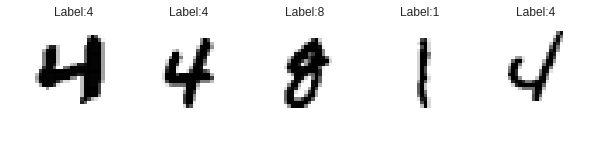

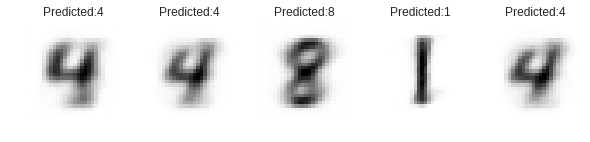

In [0]:
sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Label:" + str(mnist.test.labels[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Predicted:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()

Tahminlerin hepsi doğru ve yeniden yapılandırmlar harika görünüyor. Yaşasın!

## Çıktı Vektörlerinin Yorumlanması

Çıktı vektörlerinin  poz parametrelerinin neyi temsil ettiğini görmek için çıktı vektörlerini ayarlayalım.

İlk olarak, `cap2_output_value` NumPy dizisinin boyutunu kontrol edelim:
Her `tweaked` çıkış vektörü, poz parametrelerinden birinin (-0,5) ile (0,5) arasında değişen bir değerle arttırılması haricinde, orijinal çıktı vektörüyle aynı olacaktır.

In [0]:
caps2_output_value.shape

Tüm çıkış vektörlerindeki 16 poz parametresinin (boyutlarının) her birini değiştirecek bir fonksiyon oluşturalım. Her `tweaked` çıkış vektörü, poz parametrelerinden birinin -0,5 ile 0,5 arasında değişen bir değerle arttırılması haricinde, orijinal çıktı vektörüyle aynı olacaktır. Varsayılan olarak 11 adım (-0,5, -0,4, ..., +0,4, +0,5) olacaktır :)
Bu fonksiyon bir dizi şekil döndürür (_tweaked pose parameters_ = 16, _steps_ = 11, _batch size_ = 5, 1, 10, 16, 1):

In [0]:
def tweak_pose_parameters(output_vectors, min=-0.5, max=0.5, n_steps=11):
    steps = np.linspace(min, max, n_steps) # -0.25, -0.15, ..., +0.25
    pose_parameters = np.arange(caps2_n_dims) # 0, 1, ..., 15
    tweaks = np.zeros([caps2_n_dims, n_steps, 1, 1, 1, caps2_n_dims, 1])
    tweaks[pose_parameters, :, 0, 0, 0, pose_parameters, 0] = steps
    output_vectors_expanded = output_vectors[np.newaxis, np.newaxis]
    return tweaks + output_vectors_expanded

Tüm `tweaked` çıkış vektörlerini hesaplayalım ve sonucu kod çözücü ile besleyebilmemiz için sonucu (parametreler × adımlar × örnekler, 1, 10, 16, 1) yeniden şekillendirelim:

In [0]:
n_steps = 11

tweaked_vectors = tweak_pose_parameters(caps2_output_value, n_steps=n_steps)
tweaked_vectors_reshaped = tweaked_vectors.reshape(
    [-1, 1, caps2_n_caps, caps2_n_dims, 1])

Şimdi bu ayarlanmış çıktı vektörlerini kod çözücüye gönderelim ve ürettikleri yeniden yapılandırma sonuçlarını alalım:

In [0]:
tweak_labels = np.tile(mnist.test.labels[:n_samples], caps2_n_dims * n_steps)

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    decoder_output_value = sess.run(
            decoder_output,
            feed_dict={caps2_output: tweaked_vectors_reshaped,
                       mask_with_labels: True,
                       y: tweak_labels})

Kod çözücünün çıktısını yeniden boyutlandıralım, böylece çıktı boyutunda, küçük (tweak) adımlarda ve örneklerde kolayca yineleyebiliriz:

In [0]:
tweak_reconstructions = decoder_output_value.reshape(
        [caps2_n_dims, n_steps, n_samples, 28, 28])

Son olarak, her bir düzeltme adımı (sütun) ve her rakam için (satır) ilk 3 çıktı boyutu için tüm yeniden yapılandırmaları oluşturalım:

In [0]:
for dim in range(3):
    print("Tweaking output dimension #{}".format(dim))
    plt.figure(figsize=(n_steps / 1.2, n_samples / 1.5))
    for row in range(n_samples):
        for col in range(n_steps):
            plt.subplot(n_samples, n_steps, row * n_steps + col + 1)
            plt.imshow(tweak_reconstructions[dim, col, row], cmap="binary")
            plt.axis("off")
    plt.show()

## Sonuç

Bu colab notebook ile kapsül ağlarını tek dosyada basit bir şekilde anlatımı sağlanmıştır. Örneğin, kendi PrimaryCapsuleLayer ve DenseRoutingCapsuleLayer sınıflarını, kapsül sayısı, yönlendirme yineleme sayısı, dinamik döngü veya statik döngü kullanılıp kullanılmayacağı gibi parametreleri uygulayarak deneyebilirsiniz. Örnek olarak, TensorFlow'a dayanan Capsule Networks'ün modüler bir uygulaması,  [CapsNet-TensorFlow](https://github.com/naturomics/CapsNet-Tensorflow) projesine bir göz atın.

Bu derslik bu kadar umarım uygulamanın tadını çıkarmışsınızdır! :)